In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from scipy.optimize import curve_fit
import itertools
# from sklearn.linear_model import LinearRegression

In [10]:
datasets = glob.glob('./unassociated/*.csv')

In [38]:
library = {}
for file in datasets:
    library[file] = pd.read_csv(file, header=None)

In [40]:
    
def reformat_datasets(library):
    reformat = {}

    for key in library:

        d = library[key]
        x = []
        y = []
        yerr = []
        for i in range(d.shape[0]):
            if i % 2:
                yerr.append(d.iloc[i,1])
            else:
                x.append(d.iloc[i,0])
                y.append(d.iloc[i,1])

        yerr = np.abs(np.array(y) - np.array(yerr))

        reformat[key] = pd.DataFrame( {'MJD':x, 'Fl (E>100MeV)e-8 cm-2 s-1':y, 'Error':yerr} )

    return reformat
    
library = reformat_datasets(library)


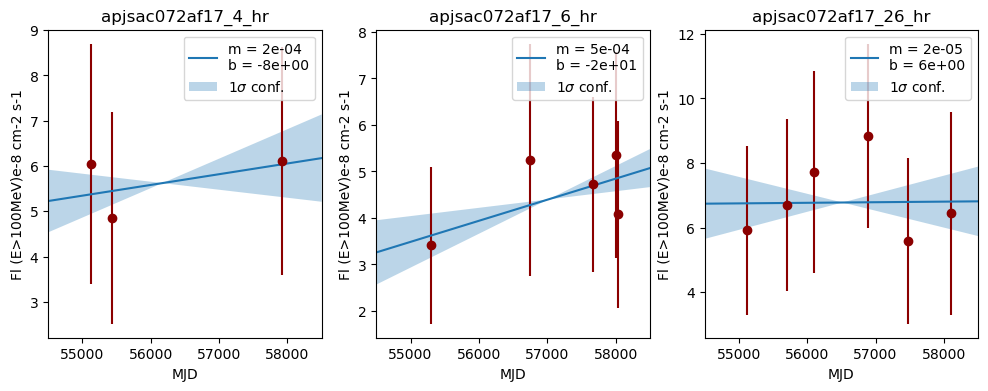

In [99]:
linear = lambda x,m,b: m*x + b

fig, axes = plt.subplots(1,3, figsize=(12,4))

for i,key in enumerate(library):

    d = library[key]

    x = d['MJD']
    y = d['Fl (E>100MeV)e-8 cm-2 s-1']
    yerr = d['Error']

    # Plot datapoints
    axes[i].errorbar(x, y, yerr = yerr, fmt='o', color = 'darkred')
    
    # Curve fitting
    fit = curve_fit(f = linear, xdata = x, ydata = y, sigma = yerr, p0 = [
        (y.iloc[-1] - y.iloc[0])/(x.iloc[-1] - x.iloc[0]), # slope
        (x.iloc[0]) # intercept
    ])

    xaxis = np.linspace(54500, 58500)
    axes[i].plot(xaxis, linear(xaxis, fit[0][0], fit[0][1]), '-', label = 'm = %.e\nb = %.e'%(fit[0][0], fit[0][1]))

    axes[i].fill_between(x = xaxis, y1 = linear(xaxis, fit[0][0] + np.sqrt(fit[1][0,0]), fit[0][1] - np.sqrt(fit[1][1,1])),\
        y2 = linear(xaxis, fit[0][0] - np.sqrt(fit[1][0,0]), fit[0][1] + np.sqrt(fit[1][1,1])),
        alpha = .3, label = r'1$\sigma$ conf.')
    # axes[i].fill_between(x = xaxis, y1 = linear(xaxis, fit[0][0] + np.sqrt(fit[1][0,0]), fit[0][1] + np.sqrt(fit[1][1,1])),\
    #     y2 = linear(xaxis, fit[0][0] - np.sqrt(fit[1][0,0]), fit[0][1] - np.sqrt(fit[1][1,1])),
    #     alpha = .3, label = r'1$\sigma$ confidence interval')
    
    axes[i].set_xlim(54500, 58500)

    axes[i].set_xlabel('MJD')
    axes[i].set_ylabel('Fl (E>100MeV)e-8 cm-2 s-1')
    axes[i].set_title(key.split('/')[-1].split('.')[0])
    axes[i].legend()

In [74]:
fit

(array([1.81010241e-05, 5.75211763e+00]),
 array([[ 2.94067793e-07, -1.66164866e-02],
        [-1.66164866e-02,  9.39234387e+02]]))